In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from mpl_toolkits import mplot3d

from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)
print(device)

cuda:0


In [3]:
##### The below class defines an Adaptable HNN of the architecture proposed by Han et al.######

class adaptable_HNN(nn.Module):
    def __init__(self, input_size, num_hidden, num_neurons, n_params):
      super(adaptable_HNN, self).__init__()
      self.input_size = input_size # dimensionality of the system
      self.num_hidden = num_hidden #No. of hidden layers in the HNN
      self.num_neurons = num_neurons #A list containing number of neurons per layer for hidden layers(should be of length num_hidden)
      self.n_params = n_params #no. of parameters

      #defining a sequential model that takes in q, p and params and gives H(q, p; params)
      self.input_model = nn.Sequential(nn.Linear(input_size+n_params, num_neurons[0]), nn.Tanh()) 
      for i in range(num_hidden-1):
        self.input_model.append(nn.Linear(num_neurons[i], num_neurons[i+1]))
        self.input_model.append(nn.Tanh())
    
      self.energy_layer = nn.Sequential(nn.Linear(num_neurons[-1], 1))


    def forward(self, q, p, params, training=True):
      self.input = torch.cat((q, p, params), dim=1)
      sequential_output = self.input_model(self.input)
      H = self.energy_layer(sequential_output)
      if training==True: #defines whether the network is in training or predicting
        dH_dq, dH_dp = torch.autograd.grad(H.sum(), (q, p), create_graph=True) #returns delH_delq, delH_delp and enforces Hamilton's equations by comparing them to -pdot and qdot
      else:
        dH_dq, dH_dp = torch.autograd.grad(H.sum(), (q, p))

      return H, -dH_dq, dH_dp


##### The below class defines an Adaptable Partial HNN of the architecture proposed by Han et al. except only for separable Hamiltonians where K=K(p)
##### and V = V(q; params). H = K(p) + V(q; params) ######

class adaptable_partial_HNN(nn.Module): #Net for Kinetic Energy or Potential Energy, depending on the 'potential' flag
  def __init__(self, input_size, num_hidden, num_neurons, n_params, potential=False):
    super(adaptable_partial_HNN, self).__init__()
    self.input_size = input_size #half the dimensionality of the system(no. of position variables)
    self.num_hidden = num_hidden #No. of hidden layers in the HNN
    self.num_neurons = num_neurons #A list containing number of neurons per layer for hidden layers(should be of length num_hidden)
    self.n_params = n_params #no. of parameters (Considering separable hamiltonians it is assumed only the potential is a function of these parameters and K = K(q) only)
    self.potential = potential #potential flag

    if self.potential: #defining a sequential model that takes in q and params and gives V(q; params)
      self.input_model = nn.Sequential(nn.Linear(input_size+n_params, num_neurons[0]), nn.Tanh())
      for i in range(num_hidden-1):
        self.input_model.append(nn.Linear(num_neurons[i], num_neurons[i+1]))
        self.input_model.append(nn.Tanh())
    
      self.energy_layer = nn.Sequential(nn.Linear(num_neurons[-1], 1))

    else: #defining a sequential model that takes in p and returns K(p)
      self.input_model = nn.Sequential(nn.Linear(input_size, num_neurons[0]), nn.Tanh())
      for i in range(num_hidden-1):
        self.input_model.append(nn.Linear(num_neurons[i], num_neurons[i+1]))
        self.input_model.append(nn.Tanh())
    
      self.energy_layer = nn.Sequential(nn.Linear(num_neurons[-1], 1))


  def forward(self, qp, params, training=True):
    if self.potential:
      self.input = torch.cat((qp, params), dim=1)
      sequential_output = self.input_model(self.input)
      V = self.energy_layer(sequential_output)
      if training==True: #defines whether the network is in training or predicting
        dH_dq = torch.autograd.grad(V.sum(), qp, create_graph=True) #gradient of V(q; params) w.r.t q ---> dp/dt
        return V, -dH_dq[0]
      else:
        dH_dq = torch.autograd.grad(V.sum(), qp) 
        return V, -dH_dq[0]

    else:
      sequential_output = self.input_model(qp.clone())
      K = self.energy_layer(sequential_output)
      if training == True:
        dH_dp = torch.autograd.grad(K.sum(), qp, create_graph=True) #gradient of K(p) w.r.t p ---> dq/dt
        return K, dH_dp[0]
      else:
        dH_dp = torch.autograd.grad(K.sum(), qp)
        return K, dH_dp[0]


In [4]:
##### The below class creates a class modelled on the architecture proposed by Chen et al. but made adaptable by adding parameter channels in the manner proposed by Han et al. #####

class adaptable_sympRNN(nn.Module):

  def __init__(self, input_size, num_hidden, num_neurons, n_params, dt, separable=True):
    super(adaptable_sympRNN, self).__init__()
    self.input_size = input_size 
    self.num_hidden = num_hidden
    self.num_neurons = num_neurons
    self.n_params = n_params 
    self.separable = separable #flag that assumes separable Hamiltonian or not
    
    self.dt = dt #the time separation between subsequent steps of the Recurrent units

    if self.separable==True:
      self.K_net = adaptable_partial_HNN(int(self.input_size/2), self.num_hidden, self.num_neurons, self.n_params, potential=False)
      self.V_net = adaptable_partial_HNN(int(self.input_size/2), self.num_hidden, self.num_neurons, self.n_params, potential=True)
    else:
      self.HNN = adaptable_HNN(self.input_size, self.num_hidden, self.num_neurons, self.n_params)

  def forward(self, q_initial, p_initial, params, final, training=True):
    batch, dim = q_initial.shape
    q, p = torch.zeros(final+1, batch, dim).to(device), torch.zeros(final+1, batch, dim).to(device)
    H = torch.zeros(final, batch, 1).to(device)
    q[0] = q_initial ; p[0] = p_initial
    for t in range(final):
      if self.separable==True:
        H[t], q[t+1], p[t+1] = self.step(q[t], p[t], params, training)
      else:
        H[t], q[t+1], p[t+1] = self.step2(q[t], p[t], params, training)

    #H[-1], _, __ = self.HNN(q[-1], p[-1], params, training)
    return H, q[1:], p[1:]

  def step(self, q, p, params, training):
    if training==True:
      #implementation of leapfrog(symplectic algorithm)
      K, qdot = self.K_net(p, params)
      q_half = q + (self.dt)/2 * qdot
      V, pdot_t = self.V_net(q_half, params)
      p_next = p + self.dt * pdot_t
      K, qdot_t = self.K_net(p_next, params)
      q_next = q_half + (self.dt)/2 * qdot_t
      V, pdot = self.V_net(q_next, params)
    else:
      K, qdot = self.K_net(p, params, training=False)
      q_half = q + (self.dt)/2 * qdot
      V, pdot = self.V_net(q_half, params, training=False)
      p_next = p + self.dt * pdot
      K, qdot = self.K_net(p_next, params, training=False)
      q_next = q_half + (self.dt)/2 * qdot
      V, pdot = self.V_net(q_next, params, training=False)
 
    return K+V, q_next, p_next

  def step2(self, q, p, params, training):
    if training==True:
      H, pdot, qdot = self.HNN(q, p, params)
      q_half = q + (self.dt)/2 * qdot
      _, pdot_t, qdot_t = self.HNN(q_half, p, params)
      p_next = p + self.dt * pdot_t
      _, pdot_half, qdot_t = self.HNN(q_half, p_next, params)
      q_next = q_half + (self.dt)/2 * qdot_t
    else:
      H, pdot, qdot = self.HNN(q, p, params, training=False)
      q_half = q + (self.dt)/2 * qdot
      _, pdot_t, qdot_t = self.HNN(q_half, p, params, training=False)
      p_next = p + self.dt * pdot_t
      _, pdot_half, qdot_t = self.HNN(q_half, p_next, params, training=False)
      q_next = q_half + (self.dt)/2 * qdot_t
 
    return H, q_next, p_next
  

  def call_V(self, q, params):
    return self.V_net(q, params, training=False)

  def call_K(self, p):
    return self.K_net(p, None, training=False)

  def call_HNN(self, q, p, params):
    return self.HNN(q, p, params, training=False)


In [5]:
#the below function takes in a adaptive symplectic recurrent neural network and performs simultaneous training and validation
def train_validate(model, q_input_train, p_input_train, params_train, q_output_train, p_output_train,
                              q_input_valid, p_input_valid, params_valid, q_output_valid, p_output_valid, 
                              n_epochs, batch_size, learning_rate=0.001): 
  
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.MSELoss() #Mean Square error loss

  num_train = int(q_input_train.shape[0]/batch_size)
  num_valid = int(q_input_valid.shape[0]/batch_size)

  time = q_output_train.shape[0] #how far in time to predict

  training_loss = np.full(n_epochs, np.nan)
  validation_loss = np.full(n_epochs, np.nan)

  with trange(n_epochs) as tr:
    #training
    for it in tr:

      train_batch_loss = 0
      model.train() #putting model in training mode
      for b in range(num_train):
        #we take slices of the data of size batch_size
        q_input_train_batch = q_input_train[b:b+batch_size, :] 
        p_input_train_batch = p_input_train[b:b+batch_size, :]
        q_output_train_batch = q_output_train[:, b:b+batch_size, :]
        p_output_train_batch = p_output_train[:, b:b+batch_size, :]

        params_train_batch = params_train[b:b+batch_size, :]

        optimizer.zero_grad()
        _, q, p = model(q_input_train_batch, p_input_train_batch, params_train_batch, time) #calling model
        
        train_loss = criterion(torch.cat((q, p), dim=2),
                               torch.cat((q_output_train_batch, p_output_train_batch), dim=2))
        
        train_batch_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()

      train_batch_loss /= num_train
      training_loss[it] = train_batch_loss

      #validate
      valid_batch_loss = 0
      model.eval()
      for b in range(num_valid):
        q_input_valid_batch = q_input_valid[b:b+batch_size, :]
        p_input_valid_batch = p_input_valid[b:b+batch_size, :]
        q_output_valid_batch = q_output_valid[:, b:b+batch_size, :]
        p_output_valid_batch = p_output_valid[:, b:b+batch_size, :]

        params_valid_batch = params_valid[b:b+batch_size, :]

        optimizer.zero_grad()
        _, q, p = model(q_input_valid_batch, p_input_valid_batch, params_valid_batch, time)
        #pdot, qdot = calc_grad(H, qtrain_batch, ptrain_batch)
        valid_loss = criterion(torch.cat((q, p), dim=2),
                               torch.cat((q_output_valid_batch, p_output_valid_batch), dim=2))

        valid_batch_loss += valid_loss.item()

      valid_batch_loss /= num_valid
      validation_loss[it] = valid_batch_loss

  return training_loss, validation_loss

In [6]:
###### The below function generates data for the Henon Heiles, to edit to another system, the RHS function can be modified to reflect the dynamical system ####

def integrate_true(tf, dim, batchsize, E_init, random_init=True, return_energy=False): 
  #random_init means random initial conditions while batchsize represents how many initial conditions are sampled
  t_final = tf ; dt = 0.001
  nsteps = int(t_final/dt)

  X = np.zeros((dim, nsteps, batchsize)) #single array that stores all the q and p of the system

  Xdot = np.zeros((dim, nsteps, batchsize))
  times = np.zeros(nsteps)
  q=int(dim/2)

  #generating parameter space 0.2, 0.4, 0.6, 0.8 and 0.1. The data is currently being generated for a multiparameter Henon Heiles potential
  a = np.arange(0.2, 1.1, 0.2) ; m=1 
  alpha = np.tile(np.meshgrid(a, a)[1].flatten(), int(batchsize/25))
  beta =  np.tile(np.meshgrid(a, a)[0].flatten(), int(batchsize/25))
  
  def rhs(Y, momentum = False):
    if momentum==False:
      return np.vstack((Y[0]/m,
                        Y[1]/m))
    else:
      return np.vstack((-Y[0] - 2*alpha*Y[0]*Y[1],
                        -Y[1] - alpha*Y[0]**2 + beta*Y[1]**2))

  
  def E(Y):
    return 0.5 * (Y[2]**2/m + Y[3]**2/m) + 0.5*(Y[0]**2 + Y[1]**2) + alpha*Y[0]**2 * Y[1] - beta*Y[1]**3/3

  def V(Y):
    return 0.5*(Y[0]**2 + Y[1]**2) + alpha*Y[0]**2 * Y[1] - beta*Y[1]**3/3

  
  #random bounded initial condition generation for initial energies E_init
  X[:q, 0, :] = np.random.uniform(-0.2, 0.2, (q, batchsize)) ; X[q:, 0, :] = np.zeros_like(X[q:, 0, :]) 
  X[-1, 0, :] = np.sqrt(np.abs(2*(E_init-V(X[:q, 0, :]))))
  Xdot[:, 0] = np.concatenate((rhs(X[q:, 0]), rhs(X[:q, 0], momentum=True)))

  Es = np.zeros((nsteps, batchsize)) #array to store energies over time
  Es[0] = E(X[:, 0])

  for t in tqdm(range(nsteps-1)):
    #data generation using leapfrog with a time step of 0.001
    X_temp = X[:q, t] + dt/2 * Xdot[:q, t]
    X[q:, t+1] = X[q:, t] + dt * rhs(X_temp, momentum=True)
    X[:q, t+1] = X_temp + dt/2 * rhs(X[q:, t+1])
    times[t+1] = times[t] + dt
    Xdot[:, t+1] = np.concatenate((rhs(X[q:, t+1]), rhs(X[:q, t+1], momentum=True)))

    Es[t+1] = E(X[:, t+1])

  if return_energy==True:
    return X[:, 100::100], Xdot[:, 100::100], Es[100::100], alpha, beta #data returned is coarse grained to time step 0.1 and transient is removed
    #return X[:, 1:], Xdot[:, 1:], Es[1:], alpha, beta #uncomment to not do coarse graining

  return X, Xdot

In [7]:
#generating data for 300 time, for 200 initial conditions divided between 4 different initial energies
X, Xdot, Es, alpha, beta = integrate_true(300, 4, 200, np.repeat(np.array([1/24, 1/12, 1/8, 1/7]), 50), return_energy=True)

100%|██████████| 299999/299999 [00:56<00:00, 5336.39it/s]


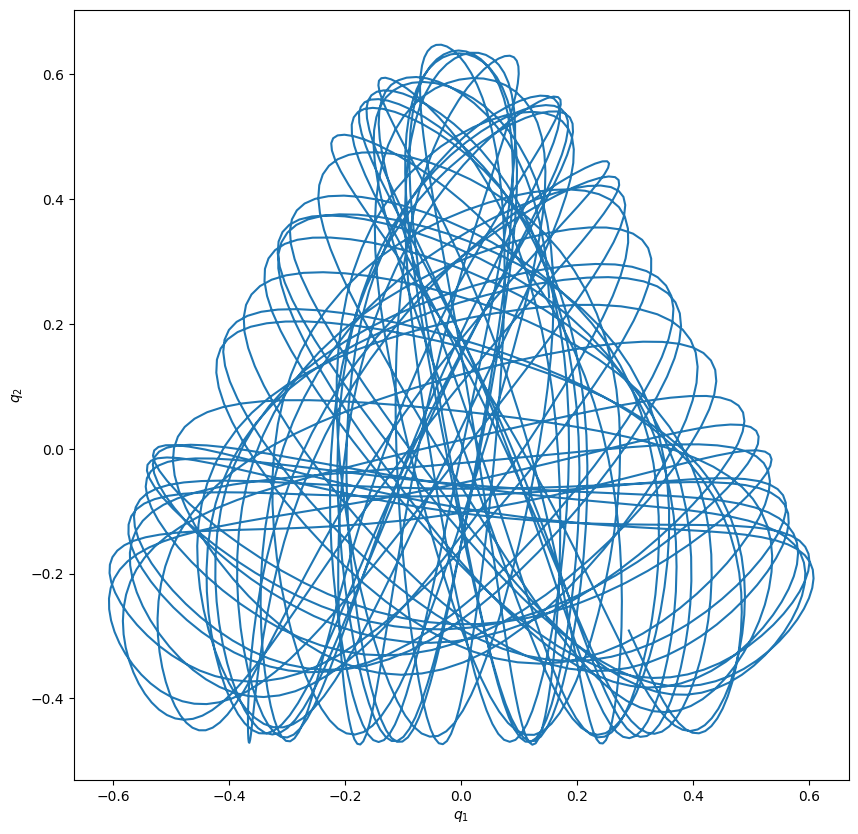

In [14]:
#example chaotic orbital plot of energy 1/7, alpha=beta=1, plot of q1 vs q2
fig=plt.figure(figsize=(10, 10))
plt.plot(X[0, :, -2], X[1, :, -2])
plt.xlabel(r'$q_1$') ; plt.ylabel(r'$q_2$')
plt.show()

In [9]:
#possible freedom to add error, none added currently
X_err = X + np.random.normal(loc=0, scale=0, size=X.shape)
Xdot_err = Xdot + np.random.normal(loc=0, scale=0, size=X.shape)

In [10]:
dim, nsteps, batchsize = X_err.shape
nsteps = nsteps-7 #for effective reshaping, taking data only 7th time step onward
l = 11 #initial step + number of steps to predict

#reshaping arrays into batches of length l
q = X_err[:int(dim/2), 7:].reshape((int(dim/2), l, int(nsteps*batchsize/l)), order='F')
q = np.transpose(q, [1, 2, 0])

p = X_err[int(dim/2):, 7:].reshape((int(dim/2), l, int(nsteps*batchsize/l)), order='F')
p = np.transpose(p, [1, 2, 0])

params = np.repeat(alpha, int(nsteps/l), axis=0)[:, None]
params = np.concatenate((params, np.repeat(beta, int(nsteps/l), axis=0)[:, None]), axis=1)

In [11]:
def shuffle(a, b, c): #function to shuffle batches
    l = a.shape[1]
    randomize = np.arange(l)
    np.random.shuffle(randomize)
    a_shuffled = a[:, randomize]
    b_shuffled = b[:, randomize]
    c_shuffled = c[randomize]

    return a_shuffled, b_shuffled, c_shuffled

def train_test_split(X, fraction=0.20): #function to split batches for training and testing
    l = X.shape[1]
    split_index = int((1 - fraction) * l)
    X_train = X[:, 0:split_index, :]
    X_test = X[:, split_index:, :]

    return X_train, X_test

def train_test_split2(X, fraction=0.20):
    l = X.shape[0]
    split_index = int((1 - fraction) * l)
    X_train = X[0:split_index, :]
    X_test = X[split_index:, :]

    return X_train, X_test

In [12]:
#data preprocessing
q, p, params = shuffle(q, p, params)
qtrain, qtest = train_test_split(q)
ptrain, ptest = train_test_split(p)
params_train, params_test = train_test_split2(params)

qtrain, qtest, ptrain, ptest, params_train, params_test = map(torch.from_numpy, (qtrain, qtest, ptrain, ptest, 
                                                                                 params_train, params_test)) #converting arrays to tensors

qtrain = qtrain.float() ; qtest = qtest.float()
ptrain = ptrain.float() ; ptest = ptest.float()
params_train = params_train.float() ;  params_test = params_test.float()

qtrain.requires_grad = True ; qtest.requires_grad = True #to allow taking gradients to enforce hamilton's equations
ptrain.requires_grad = True ; ptest.requires_grad = True

qtrain = qtrain.to(device) ; qtest = qtest.to(device)
ptrain = ptrain.to(device) ; ptest = ptest.to(device)
params_train = params_train.to(device) ;  params_test = params_test.to(device)

In [15]:
#defining a separable Adaptable Symplectic Recurrent Network of a single hidden layer of size 2048
symp_model = adaptable_sympRNN(input_size=dim, num_hidden=1, num_neurons=[2048], n_params=2, dt=0.1, separable=True)
symp_model = symp_model.to(torch.float)
symp_model = symp_model.to(device)

In [16]:
training_loss, validation_loss = train_validate(symp_model, qtrain[0], ptrain[0], params_train, qtrain[1:], ptrain[1:], 
                                                qtest[0], ptest[0], params_test, qtest[1:], ptest[1:], 
                                                n_epochs=500, batch_size=128)

100%|██████████| 500/500 [2:27:36<00:00, 17.71s/it]


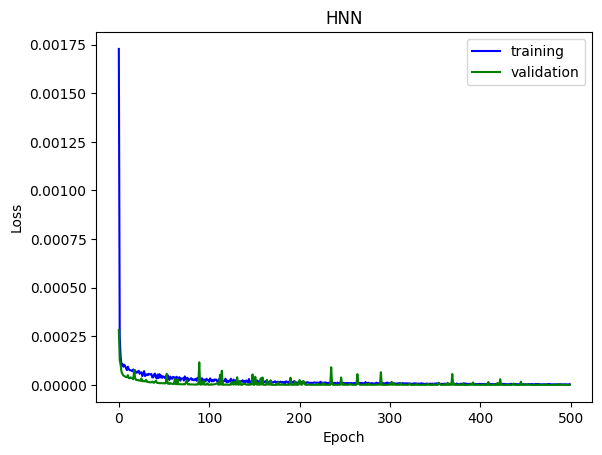

In [17]:
plt.plot(training_loss, color='b', label="training")
plt.plot(validation_loss, color='g', label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('HNN')
plt.legend()

In [67]:
#predict model on 10 testing initial conditions
H, q, p = symp_model(qtest[0, 10:20], ptest[0, 10:20], params_test[10:20], 1000)

In [68]:
H_array = H.cpu().detach().numpy()
q_out = q.cpu().detach().numpy()
p_out = p.cpu().detach().numpy()

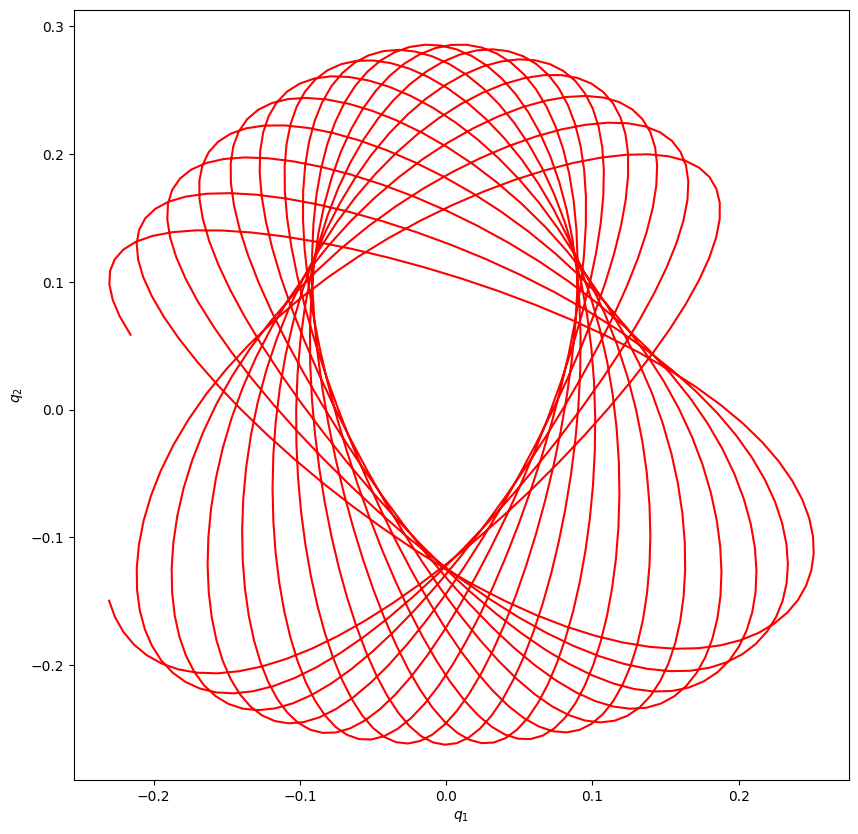

In [69]:
fig = plt.figure(figsize=(10, 10))
#plotting any for reference
plt.plot(q_out[:, 0, 0], q_out[:, 0, 1], 'r')
plt.xlabel(r'$q_1$') ; plt.ylabel(r'$q_2$')
plt.show()

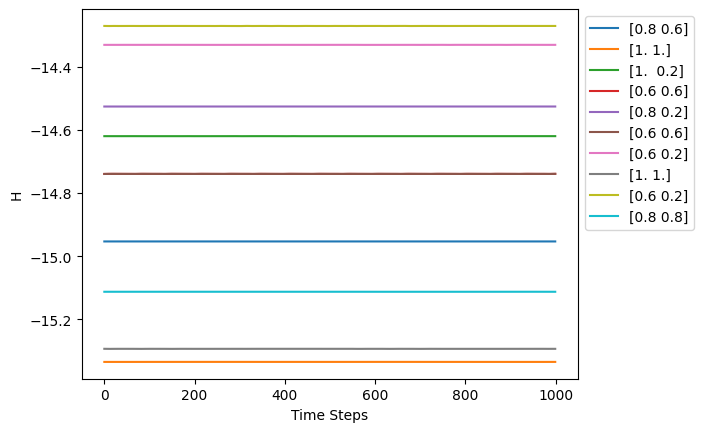

In [70]:
plt.plot(H_array[:, :, 0], label=params_test[10:20].detach().cpu().numpy()) #H-net conserved quantity
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Time Steps') ; plt.ylabel('H')
plt.show()

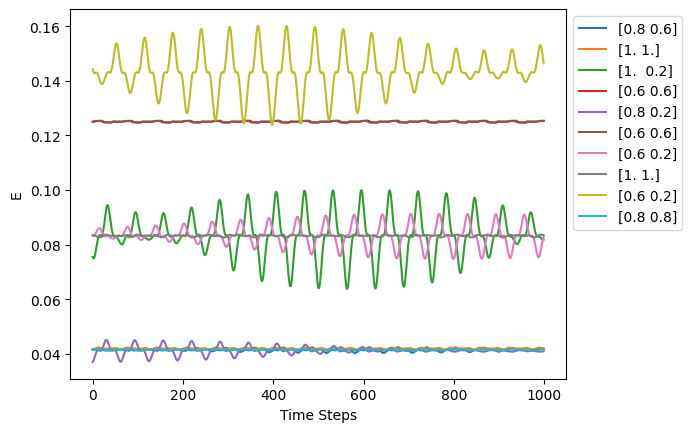

In [71]:
#### Energy predicted over 1000 time steps

def E(Y):
  m = 1 ; alpha =  params_test[10:20, 0].detach().cpu().numpy(); beta = params_test[10:20, 0].detach().cpu().numpy()
  return 0.5 * (Y[2]**2/m + Y[3]**2/m) + 0.5*(Y[0]**2 + Y[1]**2) + alpha*Y[0]**2 * Y[1] - beta*Y[1]**3/3

Y = np.vstack((np.transpose(q_out, [2, 0, 1]), np.transpose(p_out, [2, 0, 1])))
Es_test = E(Y)

plt.plot(Es_test[:, :], label=params_test[10:20].detach().cpu().numpy())

plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Time Steps') ; plt.ylabel('E')
plt.show()

In [108]:
#predict model based on specific nonchaotic initial condition
qt = torch.from_numpy(X[:2, 0, 20:21].T).float().to(device) ; qt.requires_grad=True
pt = torch.from_numpy(X[2:, 0, 20:21].T).float().to(device) ; pt.requires_grad = True
H, q, p = symp_model(qt, pt,
                     torch.from_numpy(np.concatenate((alpha[20:21][:, None], beta[20:21][:, None]), axis=1)).float().to(device), 3000)

In [109]:
H_array = H.cpu().detach().numpy()
q_out = q.cpu().detach().numpy()
p_out = p.cpu().detach().numpy()

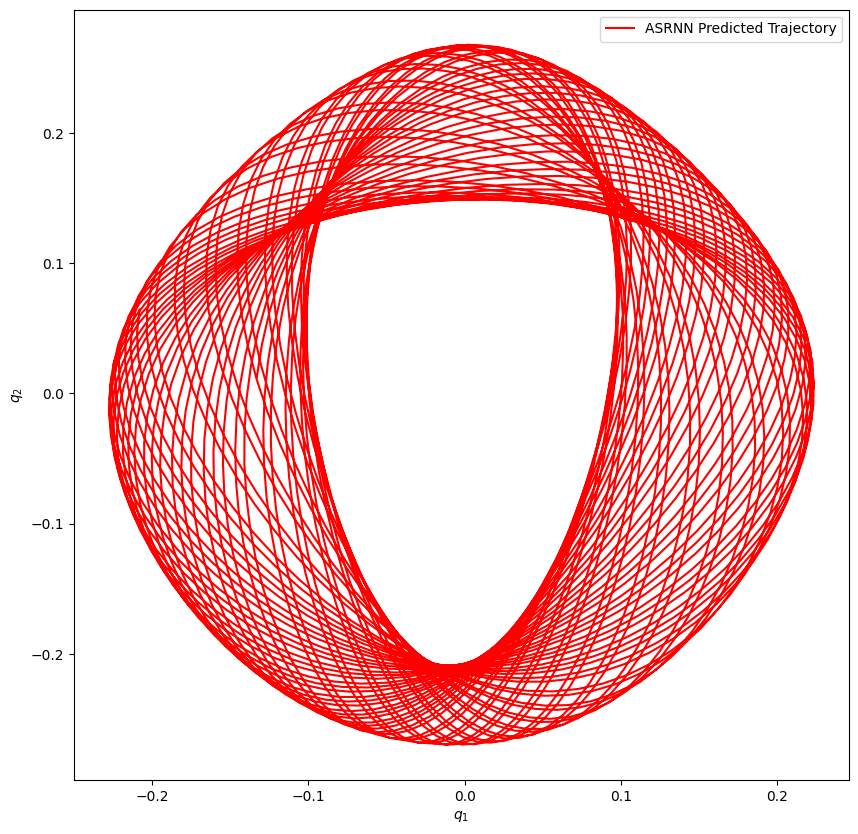

In [110]:
fig = plt.figure(figsize=(10, 10))
#plotting any for reference
plt.plot(q_out[:, 0, 0], q_out[:, 0, 1], 'r', label='ASRNN Predicted Trajectory')
plt.legend(bbox_to_anchor=((1, 1)))
plt.xlabel(r'$q_1$') ; plt.ylabel(r'$q_2$')
plt.show()

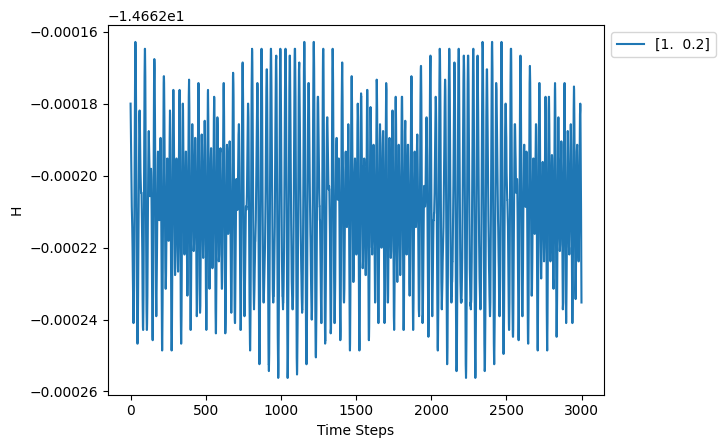

In [111]:
plt.plot(H_array[:, :, 0], label=np.concatenate((alpha[:, None], beta[:, None]), axis=1)[20]) #H-net conserved quantity
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Time Steps') ; plt.ylabel('H')
plt.show()

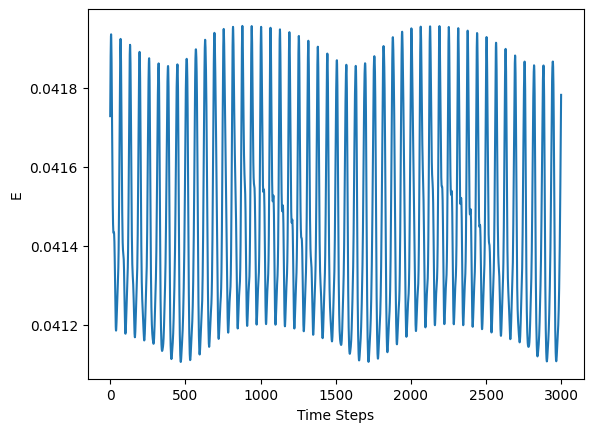

In [112]:
def E(Y, alpha, beta):
  m=1
  return 0.5 * (Y[2]**2/m + Y[3]**2/m) + 0.5*(Y[0]**2 + Y[1]**2) + alpha*Y[0]**2 * Y[1] - beta*Y[1]**3/3

Y = np.vstack((np.transpose(q_out, [2, 0, 1]), np.transpose(p_out, [2, 0, 1])))
Es_test = E(Y, alpha[20], beta[20])

plt.plot(Es_test[:, :])
plt.xlabel('Time Steps') ; plt.ylabel('E')
plt.show()

In [113]:
#predict model based on specific chaotic initial condition
qt = torch.from_numpy(X[:2, 0, -2:-1].T).float().to(device) ; qt.requires_grad=True
pt = torch.from_numpy(X[2:, 0, -2:-1].T).float().to(device) ; pt.requires_grad = True
H, q, p = symp_model(qt, pt,
                     torch.from_numpy(np.concatenate((alpha[-2:-1][:, None], beta[-2:-1][:, None]), axis=1)).float().to(device), 3000)

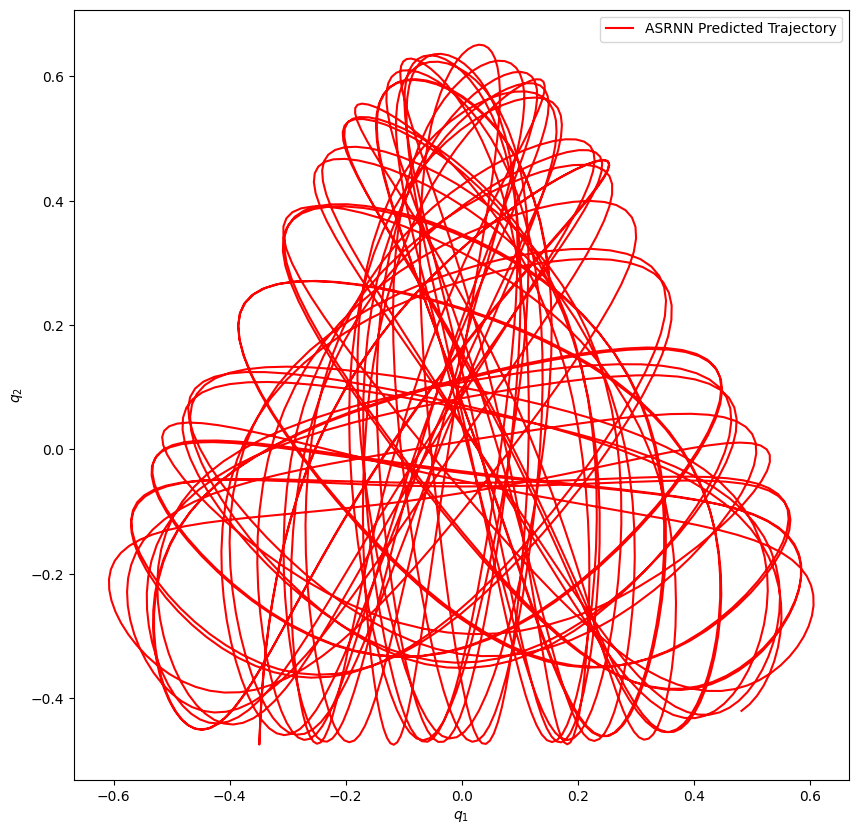

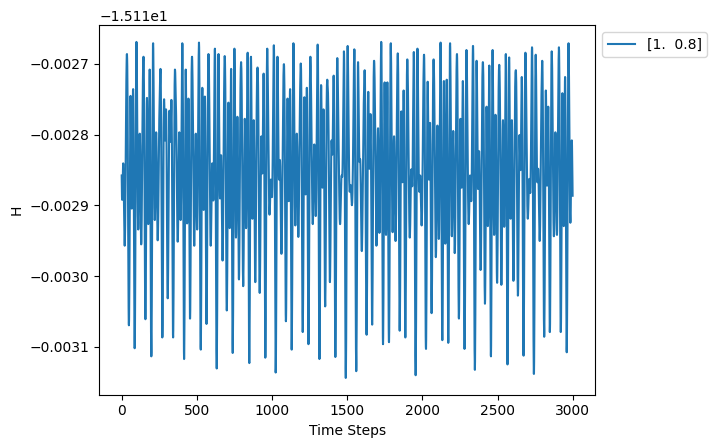

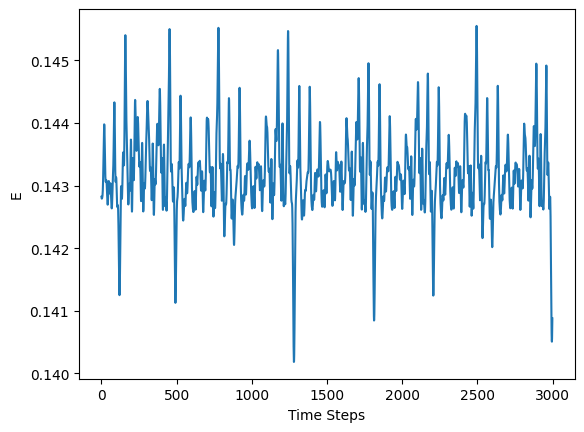

In [114]:
H_array = H.cpu().detach().numpy()
q_out = q.cpu().detach().numpy()
p_out = p.cpu().detach().numpy()

fig = plt.figure(figsize=(10, 10))
#plotting any for reference
plt.plot(q_out[:, 0, 0], q_out[:, 0, 1], 'r', label='ASRNN Predicted Trajectory')
plt.legend(bbox_to_anchor=((1, 1)))
plt.xlabel(r'$q_1$') ; plt.ylabel(r'$q_2$')
plt.show()

plt.plot(H_array[:, :, 0], label=np.concatenate((alpha[:, None], beta[:, None]), axis=1)[-2]) #H-net conserved quantity
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Time Steps') ; plt.ylabel('H')
plt.show()


Y = np.vstack((np.transpose(q_out, [2, 0, 1]), np.transpose(p_out, [2, 0, 1])))
Es_test = E(Y, alpha[-2], beta[-2])

plt.plot(Es_test[:, :])
plt.xlabel('Time Steps') ; plt.ylabel('E')
plt.show()

## Demonstration of Adaptability

In [ ]:
###### TO demonstrate Adaptability generating data of parameters 0.1, 0.3, 0.5, 0.7, 0.9
def integrate_true2(tf, dim, batchsize, E_init, random_init=True, return_energy=False): 
  #random_init means random initial conditions while batchsize represents how many initial conditions are sampled
  t_final = tf ; dt = 0.001
  nsteps = int(t_final/dt)

  X = np.zeros((dim, nsteps, batchsize)) #single array that stores all the q and p of the system

  Xdot = np.zeros((dim, nsteps, batchsize))
  times = np.zeros(nsteps)
  q=int(dim/2)

  #generating parameter space 0.2, 0.4, 0.6, 0.8 and 0.1. The data is currently being generated for a multiparameter Henon Heiles potential
  a = np.arange(0.1, 1, 0.2) ; m=1 
  alpha = np.tile(np.meshgrid(a, a)[1].flatten(), int(batchsize/25))
  beta =  np.tile(np.meshgrid(a, a)[0].flatten(), int(batchsize/25))
  
  def rhs(Y, momentum = False):
    if momentum==False:
      return np.vstack((Y[0]/m,
                        Y[1]/m))
    else:
      return np.vstack((-Y[0] - 2*alpha*Y[0]*Y[1],
                        -Y[1] - alpha*Y[0]**2 + beta*Y[1]**2))

  
  def E(Y):
    return 0.5 * (Y[2]**2/m + Y[3]**2/m) + 0.5*(Y[0]**2 + Y[1]**2) + alpha*Y[0]**2 * Y[1] - beta*Y[1]**3/3

  def V(Y):
    return 0.5*(Y[0]**2 + Y[1]**2) + alpha*Y[0]**2 * Y[1] - beta*Y[1]**3/3

  
  #random bounded initial condition generation for initial energies E_init
  X[:q, 0, :] = np.random.uniform(-0.2, 0.2, (q, batchsize)) ; X[q:, 0, :] = np.zeros_like(X[q:, 0, :]) 
  X[-1, 0, :] = np.sqrt(np.abs(2*(E_init-V(X[:q, 0, :]))))
  Xdot[:, 0] = np.concatenate((rhs(X[q:, 0]), rhs(X[:q, 0], momentum=True)))

  Es = np.zeros((nsteps, batchsize)) #array to store energies over time
  Es[0] = E(X[:, 0])

  for t in tqdm(range(nsteps-1)):
    #data generation using leapfrog with a time step of 0.001
    X_temp = X[:q, t] + dt/2 * Xdot[:q, t]
    X[q:, t+1] = X[q:, t] + dt * rhs(X_temp, momentum=True)
    X[:q, t+1] = X_temp + dt/2 * rhs(X[q:, t+1])
    times[t+1] = times[t] + dt
    Xdot[:, t+1] = np.concatenate((rhs(X[q:, t+1]), rhs(X[:q, t+1], momentum=True)))

    Es[t+1] = E(X[:, t+1])

  if return_energy==True:
    return X[:, 100::100], Xdot[:, 100::100], Es[100::100], alpha, beta #data returned is coarse grained to time step 0.1 and transient is removed
    #return X[:, 1:], Xdot[:, 1:], Es[1:], alpha, beta #uncomment to not do coarse graining

  return X, Xdot

In [118]:
X, Xdot, Es, alpha, beta = integrate_true(300, 4, 200, np.repeat(np.array([1/24, 1/12, 1/8, 1/7]), 50), return_energy=True)

100%|██████████| 299999/299999 [01:09<00:00, 4334.33it/s]


In [124]:
#predict model based on specific nonchaotic initial condition
qt = torch.from_numpy(X[:2, 0, 20:21].T).float().to(device) ; qt.requires_grad=True
pt = torch.from_numpy(X[2:, 0, 20:21].T).float().to(device) ; pt.requires_grad = True
H, q, p = symp_model(qt, pt,
                     torch.from_numpy(np.concatenate((alpha[20:21][:, None], beta[20:21][:, None]), axis=1)).float().to(device), 3000)

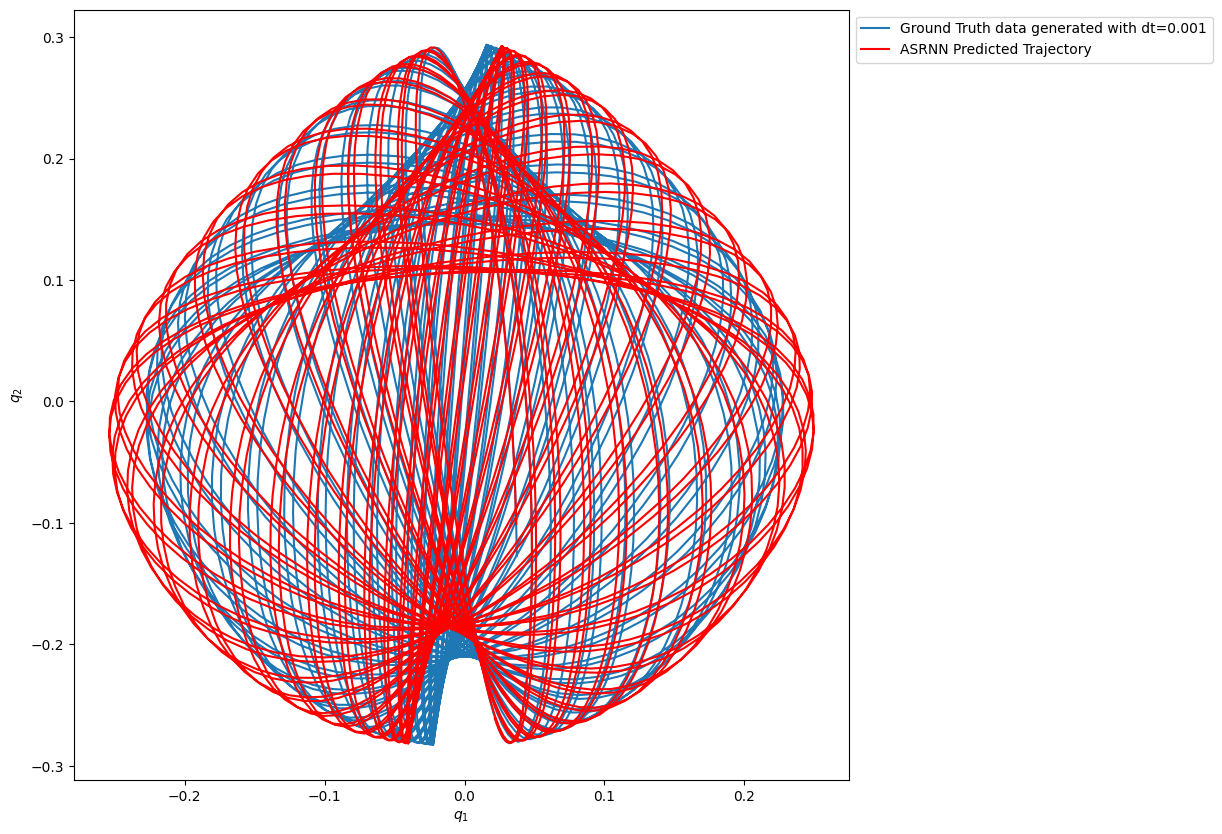

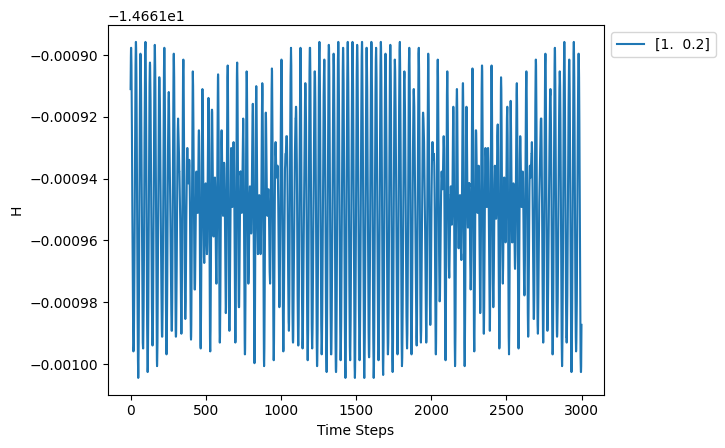

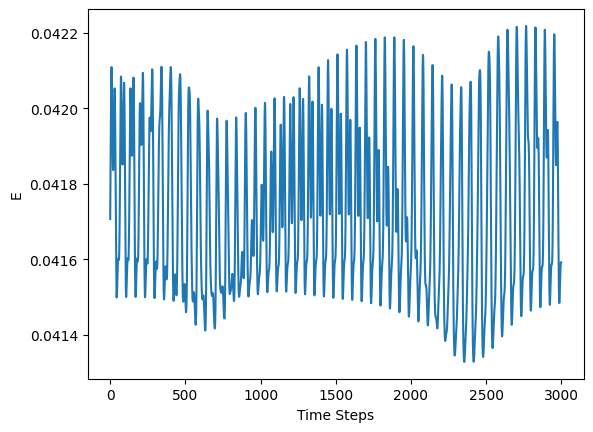

In [125]:
H_array = H.cpu().detach().numpy()
q_out = q.cpu().detach().numpy()
p_out = p.cpu().detach().numpy()

fig = plt.figure(figsize=(10, 10))
#plotting any for reference
plt.plot(X[0, :, 20], X[1, :, 20], label='Ground Truth data generated with dt=0.001')
plt.plot(q_out[:, 0, 0], q_out[:, 0, 1], 'r', label='ASRNN Predicted Trajectory')
plt.legend(bbox_to_anchor=((1, 1)))
plt.xlabel(r'$q_1$') ; plt.ylabel(r'$q_2$')
plt.show()

plt.plot(H_array[:, :, 0], label=np.concatenate((alpha[:, None], beta[:, None]), axis=1)[20]) #H-net conserved quantity
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Time Steps') ; plt.ylabel('H')
plt.show()

def E(Y, alpha, beta):
  m=1
  return 0.5 * (Y[2]**2/m + Y[3]**2/m) + 0.5*(Y[0]**2 + Y[1]**2) + alpha*Y[0]**2 * Y[1] - beta*Y[1]**3/3

Y = np.vstack((np.transpose(q_out, [2, 0, 1]), np.transpose(p_out, [2, 0, 1])))
Es_test = E(Y, alpha[20], beta[20])

plt.plot(Es_test[:, :])
plt.xlabel('Time Steps') ; plt.ylabel('E')
plt.show()

In [126]:
#predict model based on specific initial condition
qt = torch.from_numpy(X[:2, 0, -2:-1].T).float().to(device) ; qt.requires_grad=True
pt = torch.from_numpy(X[2:, 0, -2:-1].T).float().to(device) ; pt.requires_grad = True
H, q, p = symp_model(qt, pt,
                     torch.from_numpy(np.concatenate((alpha[-2:-1][:, None], beta[-2:-1][:, None]), axis=1)).float().to(device), 3000)

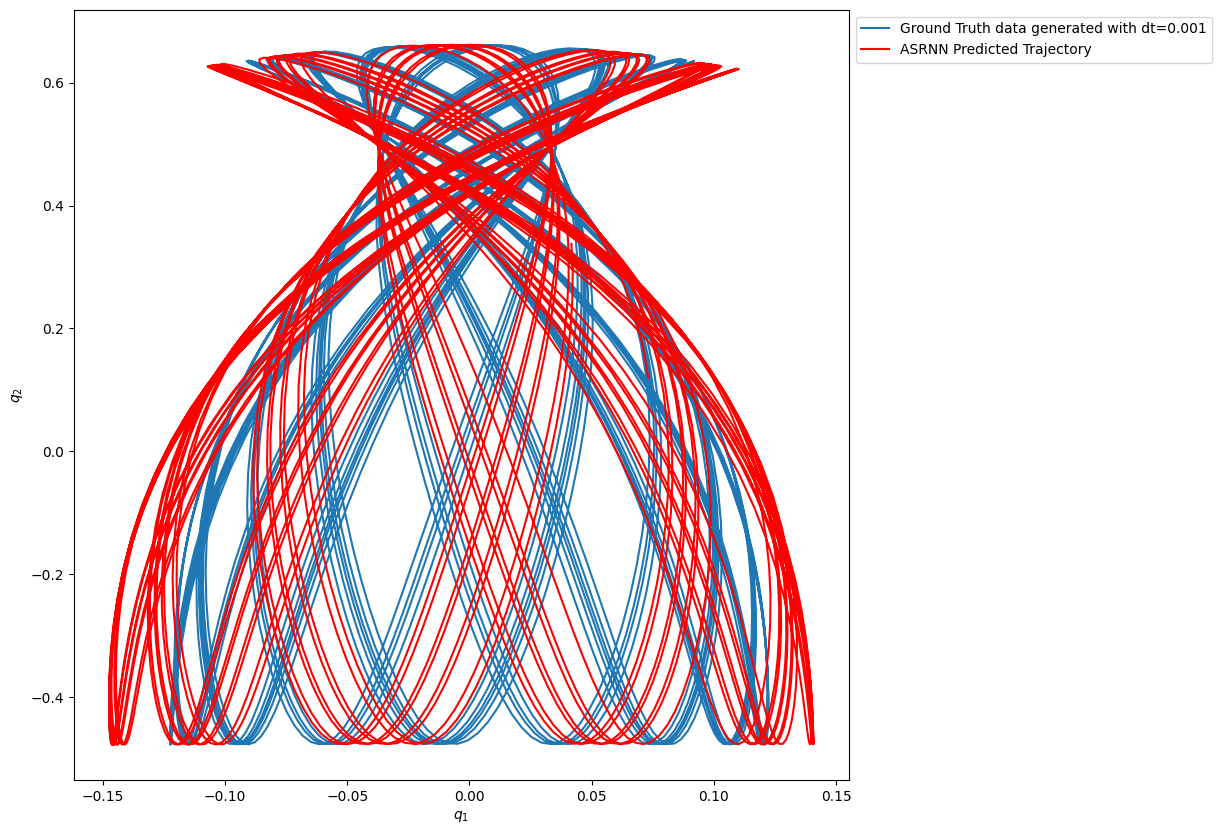

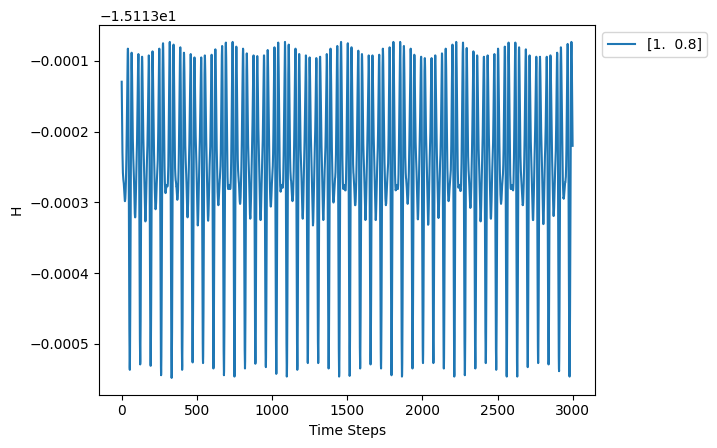

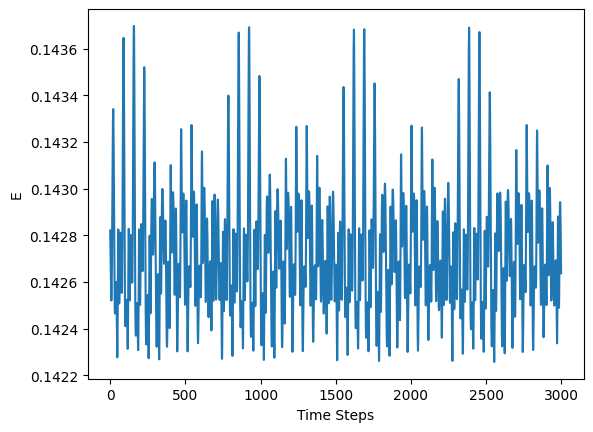

In [127]:
H_array = H.cpu().detach().numpy()
q_out = q.cpu().detach().numpy()
p_out = p.cpu().detach().numpy()

fig = plt.figure(figsize=(10, 10))
#plotting any for reference
plt.plot(X[0, :, -2], X[1, :, -2], label='Ground Truth data generated with dt=0.001')
plt.plot(q_out[:, 0, 0], q_out[:, 0, 1], 'r', label='ASRNN Predicted Trajectory')
plt.legend(bbox_to_anchor=((1, 1)))
plt.xlabel(r'$q_1$') ; plt.ylabel(r'$q_2$')
plt.show()

plt.plot(H_array[:, :, 0], label=np.concatenate((alpha[:, None], beta[:, None]), axis=1)[-2]) #H-net conserved quantity
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Time Steps') ; plt.ylabel('H')
plt.show()


Y = np.vstack((np.transpose(q_out, [2, 0, 1]), np.transpose(p_out, [2, 0, 1])))
Es_test = E(Y, alpha[-2], beta[-2])

plt.plot(Es_test[:, :])
plt.xlabel('Time Steps') ; plt.ylabel('E')
plt.show()